In [2]:
#data_analysis env
import pygam
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Inputs

In [4]:
src_meteo = r"D:\VUB\_data\_isimip_3b\model_outputs\meteo"
models = ['GFDL-ESM4', 'IPSL-CM6A-LR', 'MPI-ESM1-2-HR', 'UKESM1-0-LL']
variables = ['pre', 'pet']
scenarios = ['historical', 'ssp585']

#Read all meteorological data into a dictionary of xarray DataArrays
meteo_dict = {}
for model in models:
    for scenario in scenarios:
        for variable in variables:
            file_path = f"{src_meteo}/{model}/{scenario}/{variable}.nc"
            ds = xr.open_dataset(file_path)
            da = ds[variable]
            key = f"{model}_{scenario}_{variable}"
            meteo_dict[key] = da

In [ ]:
#stack models on keys
def stack_models(meteo_dict, model_keys):
    stacked_models_meteo = []

    for key in model_keys:
        model_da = meteo_dict[key].assign_coords(model=key.split("_")[0])
        model_da = model_da.expand_dims("model")
        stacked_models_meteo.append(model_da)

    da = xr.concat(stacked_models_meteo, dim="model")
    return da

In [ ]:
ens_mean_dict = {}
for scenario in scenarios:
    for variable in variables:
        stacked_meteo = stack_models(meteo_dict, [key for key in meteo_dict.keys() if scenario in key and variable in key])

        #compute ensemble mean
        ens_mean = stacked_meteo.mean(dim='model')
        ens_mean_dict[f"{scenario}_{variable}"] = ens_mean

In [41]:
#calculate water availability (p-pet)
water_availability = {}
for scenario in scenarios:
    pre = ens_mean_dict[f"{scenario}_pre"]
    pet = ens_mean_dict[f"{scenario}_pet"]
    wa = pre - pet
    water_availability[f"{scenario}_wa"] = wa

In [59]:
#compute monthly deltas function
def compute_mon_deltas(hydro_dict, var, hist_time_slice, fut_time_slice):
    #compute historical average of each month
    var_hist = hydro_dict[f'historical_{var}'].sel(time=hist_time_slice).resample(time='ME').sum('time')
    var_hist_mon_avg = var_hist.groupby('time.month').mean('time')
    #compute future monthly means
    var_fut = hydro_dict[f'ssp585_{var}'].sel(time=fut_time_slice).resample(time='ME').sum()
    var_change = var_fut.groupby('time.month') - var_hist_mon_avg

    #convert to dataset
    var_change = var_change.to_dataset(name=f'{var}_change')

    return var_change

In [60]:
#resample to monthly and calculate changes
hist_time_slice = slice('1971-01-01', '2000-12-31')
fut_time_slice = slice('2071-01-01', '2100-12-31')

pre_delta = compute_mon_deltas(ens_mean_dict, 'pre', hist_time_slice, fut_time_slice)
pet_delta = compute_mon_deltas(ens_mean_dict, 'pet', hist_time_slice, fut_time_slice)
wa_delta = compute_mon_deltas(water_availability, 'wa', hist_time_slice, fut_time_slice)

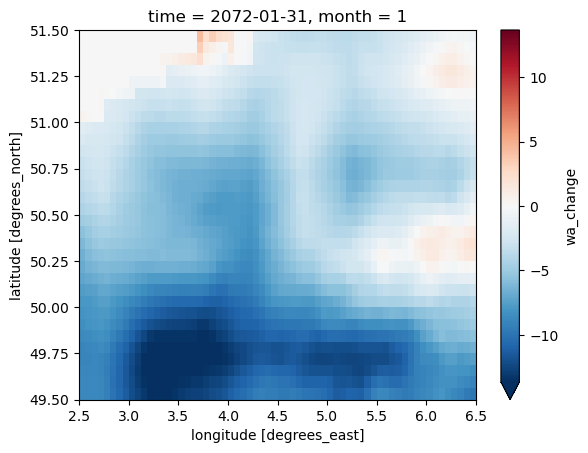

In [69]:
wa_delta['wa_change'][12].plot(robust=True)